# **ENTRENAMIENTO DE MODELOS DE MACHINE LEARNING Y EVALUACIÓN**

Nuestro problema es de tipo clasificación. El objetivo es predecir si a partir de un terremoto con ciertas características, se producirá un tsunami.

Nuestro target es: **oceanicTsunami**: donde 0 es que no hay tsunami tras el terremoto y 1 es que se produce un tsunami.

Como es un problema de clasificación y las clases de nuestro target están desbalanceadas, lo más conveniente es:
* **Score principal: F1Score**: porque nos interesa tanto el recall como la precisión.
* Score secundario: Recall: para destacar que el modelo detecta todos los tsunamis reales (a costa de algunos falsos positivos). En la vida real, esto nos hace ser precavidos y salvar vidas. No nos podemos permitir falsos negativos.

Los modelos de ML supervisados que voy a utilizar son:

* 1.- Logistic Regression
* 2.- Random Forest
* 3.- XGBoost
* 4.- LightGBM
* 5.- CatBoost
* 6.- Suport Vector Machine (SVM)
* 7.- k-Nearest Neighbors (kNN)


Los modelos de ML no supervisados:

* 8.- DBSCAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import pickle

In [2]:
train=pd.read_csv(r'C:\Users\isabe\Documents\Thebridge\Machine learning datasets\CARPETA GITHUB\Data\train_test\train.csv')

In [3]:
train

,year,latitude_eq,longitude_eq,country,regionCode_eq,intensity,eqDepth,magnitude_Mw,oceanicTsunami
0,2014,38.215,-122.312,USA,150,8.0,11.0,6.000,0
1,1841,52.000,158.000,RUSSIA,50,11.0,30.0,7.698,1
2,1938,37.100,141.700,JAPAN,30,NaN,30.0,7.229,1
3,2022,29.274,81.149,NEPAL,60,7.0,18.0,5.700,0
4,1947,28.500,94.000,INDIA,60,NaN,60.0,7.363,0
...,...,...,...,...,...,...,...,...,...
2806,1986,27.727,66.650,PAKISTAN,60,NaN,43.0,5.085,0
2807,2015,-2.141,28.897,RWANDA,10,5.0,11.0,5.800,0
2808,1993,30.149,50.814,IRAN,140,NaN,33.0,5.400,0
2809,2017,-6.246,155.172,PAPUA NEW GUINEA,170,9.0,135.0,7.900,1


In [4]:
X = train.drop('oceanicTsunami', axis=1)
y = train['oceanicTsunami']

In [5]:
X

,year,latitude_eq,longitude_eq,country,regionCode_eq,intensity,eqDepth,magnitude_Mw
0,2014,38.215,-122.312,USA,150,8.0,11.0,6.000
1,1841,52.000,158.000,RUSSIA,50,11.0,30.0,7.698
2,1938,37.100,141.700,JAPAN,30,NaN,30.0,7.229
3,2022,29.274,81.149,NEPAL,60,7.0,18.0,5.700
4,1947,28.500,94.000,INDIA,60,NaN,60.0,7.363
...,...,...,...,...,...,...,...,...
2806,1986,27.727,66.650,PAKISTAN,60,NaN,43.0,5.085
2807,2015,-2.141,28.897,RWANDA,10,5.0,11.0,5.800
2808,1993,30.149,50.814,IRAN,140,NaN,33.0,5.400
2809,2017,-6.246,155.172,PAPUA NEW GUINEA,170,9.0,135.0,7.900


*Recordatorio*

Para tratar los huecos de la columna intensity, teníamos esta función, que la vamos a utilizar como un transformer en nuestro pipeline. Así seguirá el mismo proceso con el test.

### MODELOS SUPERVISADOS:
* 1.- Logistic Regression
* 2.- Random Forest
* 3.- XGBoost
* 4.- LightGBM
* 5.- CatBoost
* 6.- Suport Vector Machine (SVM)
* 7.- k-Nearest Neighbors (kNN)

In [6]:
#dividimos las columnas en categóricas y numéricas

cat_features = ['country', 'regionCode_eq']
num_features = ['year', 'latitude_eq', 'longitude_eq', 'eqDepth', 'magnitude_Mw', 'intensity']

In [7]:
def fill_intensity_by_magnitude(df):
    df = df.copy()
    
    df['intensity'] = df.groupby('magnitude_Mw')['intensity'].transform(
        lambda x: x.fillna(x.median())
    )
    global_median = df['intensity'].median()
    df['intensity'] = df['intensity'].fillna(global_median)
    
    df['intensity'] = df['intensity'].round().astype(int)
    
    return df

intensity_imputer = FunctionTransformer(fill_intensity_by_magnitude)


In [8]:
#definimos los preprocesados para las numéricas y las categóricas.

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [9]:
# guardamos en un diccionario los modelos que vamos a utilizar

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42), 
    'KNN': KNeighborsClassifier()
}

# Definimos como queremos el cv, en este caso stratificado y dividido en 5 partes

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [10]:
# Creamos un diccionario vacío donde guardamos las métricas de cada fold del cross validation para cada modelo.

# Iteramos para cada modelo definido en el diccionario con un pipeline donde se imputan los valores faltandes de la intensidad y se preprocesan las columnas

# Se balancean las clases mediante SMOTE

fold_results = {}

for name, model in models.items():
    print(f"--- Evaluando modelo: {name} ---")
    
    pipe = ImbPipeline([
        ('intensity_imputer', intensity_imputer), 
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    
    scores = cross_validate(pipe, X, y, cv=cv, scoring=['f1', 'recall'], return_train_score=False)
    
    f1_scores = scores['test_f1']
    recall_scores = scores['test_recall']
    
    fold_results[name] = {
        'f1_per_fold': f1_scores,
        'recall_per_fold': recall_scores
    }
    
    print(f"F1 por fold: {f1_scores}")
    print(f"Recall por fold: {recall_scores}")

# Nota: aunque salgan tantos mensajes de warning para XGBost y LightGBM no son mensajes de error, nos advierte de que no se han utilizado ciertas columnas creadas por el preprocesado.

--- Evaluando modelo: LogisticRegression ---
F1 por fold: [0.70588235 0.71177945 0.70531401 0.70918367 0.70351759]
Recall por fold: [0.82142857 0.8502994  0.86904762 0.82738095 0.83333333]
--- Evaluando modelo: RandomForest ---
F1 por fold: [0.76923077 0.72159091 0.74929577 0.71386431 0.74431818]
Recall por fold: [0.80357143 0.76047904 0.79166667 0.7202381  0.7797619 ]
--- Evaluando modelo: XGBoost ---


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:26] WARNING: C:\actio

F1 por fold: [0.75581395 0.76608187 0.76243094 0.72839506 0.76878613]
Recall por fold: [0.77380952 0.78443114 0.82142857 0.70238095 0.79166667]
--- Evaluando modelo: LightGBM ---
[LightGBM] [Info] Number of positive: 1577, number of negative: 1577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1689
[LightGBM] [Info] Number of data points in the train set: 3154, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1577, number of negative: 1577
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set

c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1578, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1578, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1578, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
F1 por fold: [0.75783476 0.77514793 0.75956284 0.75659824 0.77746479]
Recall por fold: [0.79166667 0.78443114 0.82738095 0.76785714 0.82142857]
--- Evaluando modelo: CatBoost ---


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F1 por fold: [0.76404494 0.73829201 0.7712766  0.76487252 0.75824176]
Recall por fold: [0.80952381 0.80239521 0.86309524 0.80357143 0.82142857]
--- Evaluando modelo: SVM ---
F1 por fold: [0.71       0.69897959 0.71744472 0.71212121 0.70408163]
Recall por fold: [0.8452381  0.82035928 0.86904762 0.83928571 0.82142857]
--- Evaluando modelo: KNN ---
F1 por fold: [0.67336683 0.68766404 0.69565217 0.69312169 0.67733333]
Recall por fold: [0.79761905 0.78443114 0.80952381 0.7797619  0.75595238]



Matriz de confusión - LogisticRegression:
[[1522  450]
 [ 134  705]]


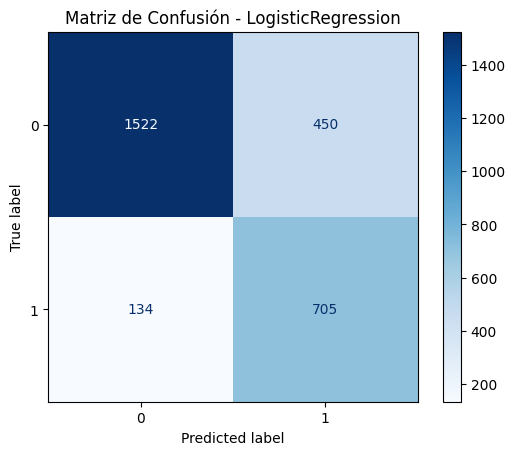


Matriz de confusión - RandomForest:
[[1709  263]
 [ 192  647]]


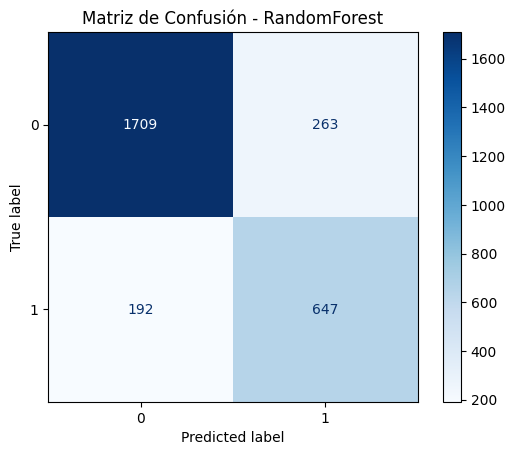

c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:45] WARNING: C:\actio


Matriz de confusión - XGBoost:
[[1743  229]
 [ 189  650]]


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


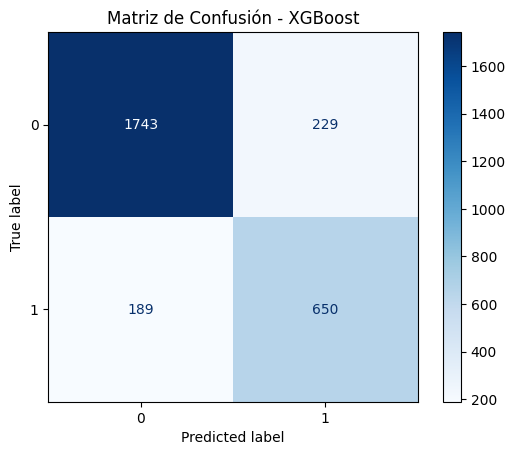

[LightGBM] [Info] Number of positive: 1577, number of negative: 1577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1689
[LightGBM] [Info] Number of data points in the train set: 3154, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1577, number of negative: 1577
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 3154, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1578, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1701
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1578, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1716
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1578, number of negative: 1578
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points in the train set: 3156, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Matriz de confusión - LightGBM:
[[1730  242]
 [ 169  670]]


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


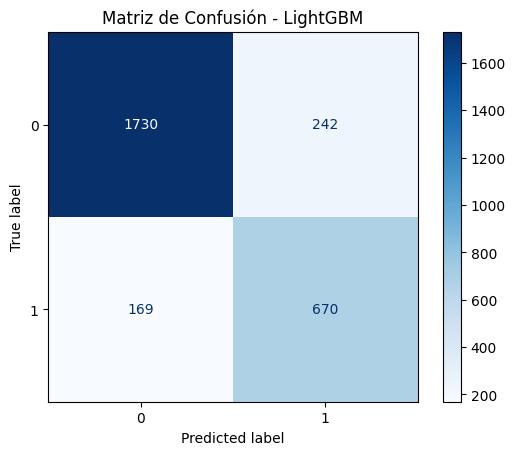


Matriz de confusión - CatBoost:
[[1687  285]
 [ 151  688]]


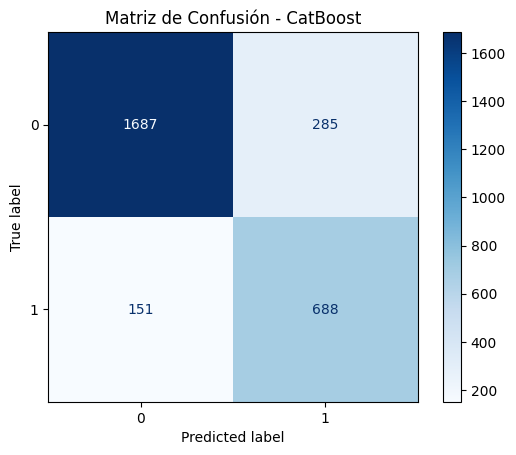


Matriz de confusión - SVM:
[[1528  444]
 [ 135  704]]


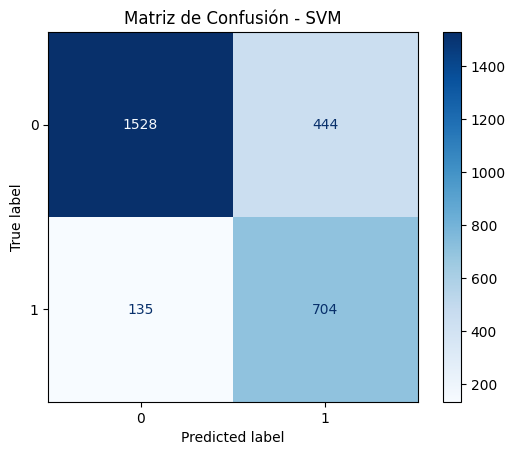


Matriz de confusión - KNN:
[[1547  425]
 [ 180  659]]


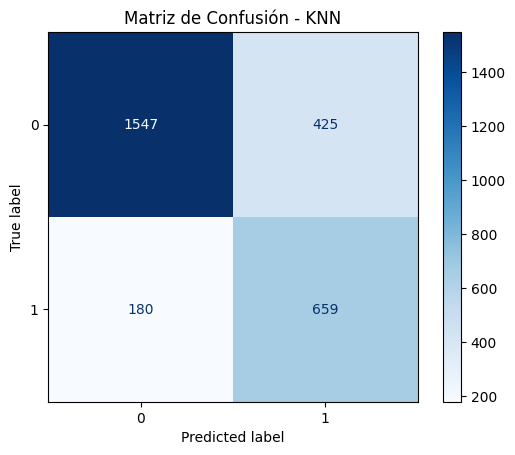

In [11]:
# Iteramos para cada modelo para obtener las matrices de confusión.


for name, model in models.items():
    pipe = ImbPipeline([
        ('intensity_imputer', intensity_imputer),
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    
    try:
        y_pred = cross_val_predict(pipe, X, y, cv=cv)
        cm = confusion_matrix(y, y_pred)
        print(f"\nMatriz de confusión - {name}:")
        print(cm)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Matriz de Confusión - {name}")
        plt.show()
        
    except ValueError:
        print(f"No se pudo calcular la matriz de confusión para {name}")

In [12]:
# Los resultados de la evaluación de cada modelo con los scores definidos. Hace la media de todos los folds de cada modelo

summary_results = {}

for name, metrics in fold_results.items():
    summary_results[name] = {
        'f1_mean': np.mean(metrics['f1_per_fold']),
        'recall_mean': np.mean(metrics['recall_per_fold'])
    }

results_df = pd.DataFrame(summary_results).T.fillna(0).sort_values(by='f1_mean', ascending=False)
print("--- Resumen de resultados (media CV) ---")
print(results_df)

--- Resumen de resultados (media CV) ---
                     f1_mean  recall_mean
LightGBM            0.765322     0.798553
CatBoost            0.759346     0.820003
XGBoost             0.756302     0.774743
RandomForest        0.739660     0.771143
SVM                 0.708525     0.839072
LogisticRegression  0.707135     0.840298
KNN                 0.685428     0.785458


In [13]:
# Obtenemos el mejor modelo según nuestro score F1.

best_model_name = results_df.index[0]
print(f"El mejor modelo según F1-score es: {best_model_name}")
best_model = models[best_model_name]

El mejor modelo según F1-score es: LightGBM


In [14]:
final_pipe = ImbPipeline([
    ('intensity_imputer', intensity_imputer),
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', best_model)
])

final_pipe.fit(X, y)

[LightGBM] [Info] Number of positive: 1972, number of negative: 1972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('intensity_imputer',
                 FunctionTransformer(func=<function fill_intensity_by_magnitude at 0x0000021EDF1536D0>)),
                ('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'latitude_eq',
                                                   'longitude_eq', 'eqDepth',
                                                   'magnitude_Mw',
                                                   'intensity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country',
                                                   'regionCode_eq'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

In [15]:
# Vamos a ver que columnas han tenido mayor importancia en cada modelo. Para los modelos de árboles, mediante feature importance. Para los modelos lineales con coef_. SVM y KNN no tienen feature importance.

# Luego guardamos el top 10 de las mejores columnas para cada modelo en un Dataframe.

tree_models = ['RandomForest', 'XGBoost', 'LightGBM', 'CatBoost']


linear_models = ['LogisticRegression']

feature_importances = {}

for name, model in models.items():
    pipe = ImbPipeline([
        ('intensity_imputer', intensity_imputer),
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])
    

    pipe.fit(X, y)
    

    preprocessed_cols = pipe.named_steps['preprocess'].get_feature_names_out()
    
    clf = pipe.named_steps['clf']
    
    if name in tree_models:
        importances = clf.feature_importances_
    elif name in linear_models:
        importances = np.abs(clf.coef_).flatten()
    else:
        print(f" {name} no tiene feature importance disponible.")
        continue
    
    feature_importances[name] = pd.DataFrame({
        'feature': preprocessed_cols,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    
    print(f"--- Feature importance - {name} ---")
    display(feature_importances[name].head(10))

--- Feature importance - LogisticRegression ---


,feature,importance
28,cat__country_CHILE,2.478287
86,cat__country_NEW CALEDONIA,2.434348
63,cat__country_JAPAN,2.330417
59,cat__country_IRAN,2.296404
124,cat__country_UKRAINE,2.226513
29,cat__country_CHINA,2.022900
98,cat__country_RUSSIA,1.969352
136,cat__regionCode_eq_40,1.930731
132,cat__regionCode_eq_10,1.895419
123,cat__country_UK,1.779266


--- Feature importance - RandomForest ---


,feature,importance
4,num__magnitude_Mw,0.214828
2,num__longitude_eq,0.135833
3,num__eqDepth,0.114280
1,num__latitude_eq,0.102447
0,num__year,0.095721
5,num__intensity,0.068364
136,cat__regionCode_eq_40,0.022987
29,cat__country_CHINA,0.016635
63,cat__country_JAPAN,0.015475
149,cat__regionCode_eq_170,0.014508


--- Feature importance - XGBoost ---


c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:46:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,feature,importance
136,cat__regionCode_eq_40,0.145907
59,cat__country_IRAN,0.071452
146,cat__regionCode_eq_140,0.051947
29,cat__country_CHINA,0.036860
58,cat__country_INDONESIA,0.032907
4,num__magnitude_Mw,0.030513
11,cat__country_ARGENTINA,0.030070
48,cat__country_GREECE,0.029946
135,cat__regionCode_eq_30,0.028986
138,cat__regionCode_eq_60,0.028768


[LightGBM] [Info] Number of positive: 1972, number of negative: 1972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- Feature importance - LightGBM ---


,feature,importance
2,num__longitude_eq,536
4,num__magnitude_Mw,484
0,num__year,476
3,num__eqDepth,433
1,num__latitude_eq,395
5,num__intensity,170
28,cat__country_CHILE,42
63,cat__country_JAPAN,38
48,cat__country_GREECE,37
29,cat__country_CHINA,28


--- Feature importance - CatBoost ---


,feature,importance
4,num__magnitude_Mw,22.628997
2,num__longitude_eq,15.813787
0,num__year,11.989306
3,num__eqDepth,10.524941
5,num__intensity,7.597484
1,num__latitude_eq,5.531876
136,cat__regionCode_eq_40,2.929580
63,cat__country_JAPAN,2.107148
28,cat__country_CHILE,1.998768
29,cat__country_CHINA,1.710703


 SVM no tiene feature importance disponible.
 KNN no tiene feature importance disponible.


### ANÁLISIS DE LOS RESULTADOS DE LOS MODELOS SUPERVISADOS:

Teniendo en cuenta los scorings elegidos y que tener falsos negativos nos perjudica enormemente llegamos a las siguientes conclusiones:

--- Resumen de resultados (media CV) ---

| Modelo              | f1_mean  | recall_mean |
|--------------------|----------|-------------|
| LightGBM           | 0.765322 | 0.798553    |
| CatBoost           | 0.759346 | 0.820003    |
| XGBoost            | 0.756302 | 0.774743    |
| RandomForest       | 0.739660 | 0.771143    |
| SVM                | 0.708525 | 0.839072    |
| LogisticRegression | 0.707135 | 0.840298    |
| KNN                | 0.685428 | 0.785458    |

El mejor modelo por métricas es LightGBM.

En cuanto a la matriz de confusión, LightGBM se encuentra en 4a posición con menos False Negatives. En este sentido, el modelo que menos False Negatives. tiene es Logistic Regresion, aunque por métricas es el penúltimo.

In [16]:
# Guardamos cada modelo. Para ello, primero los entrenamos sin el crossvalidation, con todo el train.

trained_models = {}

for name, model in models.items():
    pipe = ImbPipeline([
        ('intensity_imputer', intensity_imputer),
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', model)
    ])

    pipe.fit(X, y)
    
    trained_models[name] = pipe
    
    with open(f'pipeline_{name}.pkl', 'wb') as f:
        pickle.dump(pipe, f)

c:\Users\isabe\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [19:46:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 1972, number of negative: 1972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 3944, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


### MODELO NO SUPERVISADO

* 8.- DBSCAN

In [17]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [18]:
# Aplicamos el transformer de intensity para DBSCAND, seleccionamos solo las columnas numéricas y le imputamos la media de su columna si hay huecos. También escalamos los datos.

X_dbscan = intensity_imputer.transform(X)

num_features = X_dbscan.select_dtypes(include=np.number).columns
X_numeric = X_dbscan[num_features]

numeric_imputer = SimpleImputer(strategy='median')
X_numeric_clean = numeric_imputer.fit_transform(X_numeric)

X_scaled = StandardScaler().fit_transform(X_numeric_clean)


In [19]:
# Aplicamos DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

In [20]:
# Contamos el número de puntos de cada cluster

cluster_counts = pd.Series(clusters).value_counts().sort_index()
print("\nNúmero de puntos por cluster:")
print(cluster_counts)

#La mayoría son outliers.


Número de puntos por cluster:
-1     1133
 0       15
 1      213
 2      173
 3       20
 4      159
 5      144
 6       64
 7       59
 8      160
 9       39
 10      31
 11       6
 12      60
 13      23
 14      24
 15      15
 16      13
 17      56
 18      31
 19      39
 20      29
 21       6
 22       7
 23      49
 24       8
 25      50
 26       9
 27       5
 28       4
 29       9
 30       5
 31       5
 32       7
 33       5
 34       5
 35       7
 36       6
 37       5
 38      12
 39       5
 40       5
 41      12
 42       9
 43       6
 44      13
 45       6
 46       5
 47       5
 48       6
 49       4
 50       5
 51       6
 52       5
 53       4
 54       5
Name: count, dtype: int64


In [21]:
# Calculamos el score de silueta si hat un número suficiente de clusters, al menos 2.

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
if n_clusters > 1:
    score = silhouette_score(X_scaled, clusters)
    print(f"Silhouette Score: {score:}")
else:
    print("No hay suficientes clusters válidos para calcular silhouette score")


Silhouette Score: -0.12527004507905254


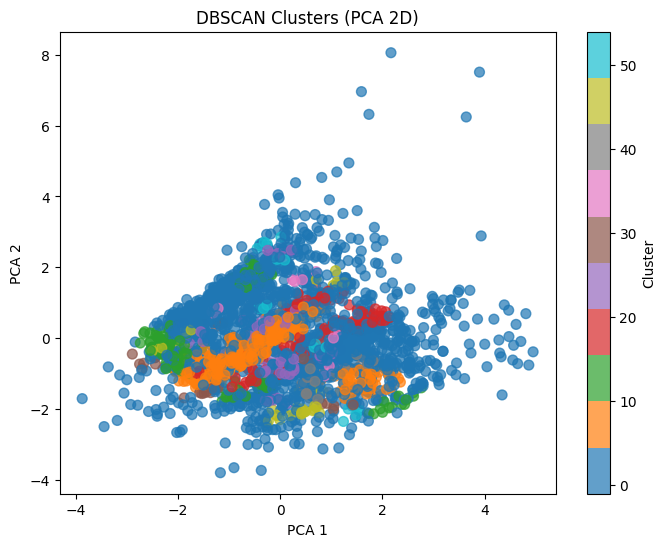

In [22]:
# Queremos ver los clusters, pero necesitamos tenerlo en dos dimensiones, por lo que aplicaremos PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Graficar clusters
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', s=50, alpha=0.7)
plt.title('DBSCAN Clusters (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [23]:
# Como los resultados no son muy buenos, vamos a probar con otros eps iterando.

eps_values = [0.3, 0.5, 0.7, 1.0, 1.5,2]
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    clusters = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    
    if n_clusters > 1:
        score = silhouette_score(X_scaled, clusters)
        print(f"eps={eps:} | Clusters={n_clusters} | Silhouette Score={score:}")
    else:
        print(f"eps={eps:} | Clusters={n_clusters} | Silhouette Score: No se puede calcular")

#El que mejor funciona es con eps 1.5

eps=0.3 | Clusters=42 | Silhouette Score=-0.3778121063722753
eps=0.5 | Clusters=55 | Silhouette Score=-0.12527004507905254
eps=0.7 | Clusters=45 | Silhouette Score=-0.05344438621533569
eps=1.0 | Clusters=7 | Silhouette Score=0.15486148486386228
eps=1.5 | Clusters=4 | Silhouette Score=0.38091399722130614
eps=2 | Clusters=2 | Silhouette Score=0.6143494421242199


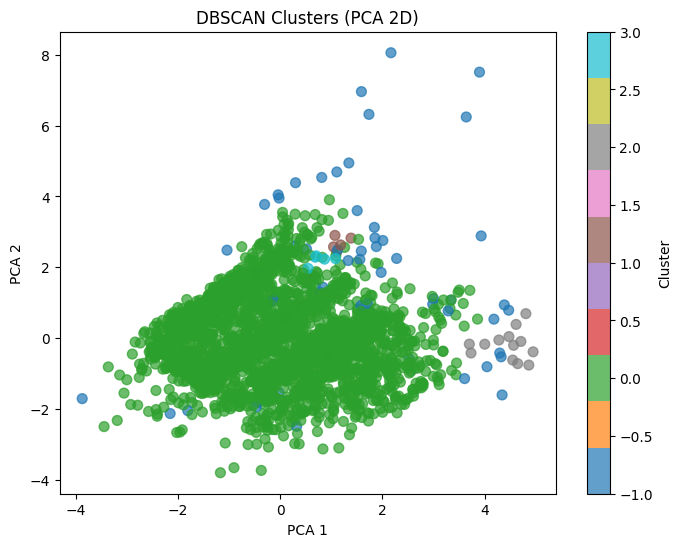

In [24]:

dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Grafico clusters con 1.5 de eps

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', s=50, alpha=0.7)
plt.title('DBSCAN Clusters (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

Como conclusión vemos que no da nueva información relevante.